2018.10.27: Multiple states: Time series

In [1]:
import sys,os
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting parameter:
np.random.seed(1)

n = 10 # number of positions
m = 5 # number of values at each position
l = 2*((n*m)**2) # number of samples

g = 1.

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

i1tab,i2tab = itab(n,m)

In [4]:
# generate coupling matrix w0:
def generate_coupling(n,m,g):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,:] -= w[i1:i2,:].mean(axis=0)            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            
        
    return w

In [5]:
w0 = generate_coupling(n,m,g)

In [6]:
# 2018.10.27: generate time series by MCMC
def generate_sequences_MCMC(w,n,m,l): 
    #print(i1tab,i2tab)
    
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 100

    for t in range(l-1):
        h = np.sum(s[t,:]*w[:,:],axis=1)
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]
                
            k = np.random.randint(0,m)              
            for itrial in range(ntrial):            
                k2 = np.random.randint(0,m)                
                while k2 == k:
                    k2 = np.random.randint(0,m)
                               
                if np.exp(h[i1+k2]- h[i1+k]) > np.random.rand():
                    k = k2
            
            s[t+1,i1:i2] = 0.
            s[t+1,i1+k] = 1.
            
    return s            

In [7]:
s = generate_sequences_MCMC(w0,n,m,l) 

In [8]:
print(s[:5])

[[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 0.]]


In [9]:
# recover s0 from s
s0 = np.argmax(s.reshape(-1,m),axis=1).reshape(-1,n)

In [10]:
def eps_ab_func(s0,m):
    l,n = s0.shape
    eps = np.zeros((n,l-1,m,m))
    for i in range(n):
        for t in range(l-1):            
            eps[i,t,:,int(s0[t+1,i])] = -1.
            eps[i,t,int(s0[t+1,i]),:] = 1.
    return eps

In [11]:
eps_ab_all = eps_ab_func(s0,m)

In [16]:
l = s.shape[0]

s_av = np.mean(s[:-1],axis=0)
ds = s[:-1] - s_av
c = np.cov(ds,rowvar=False,bias=True)
#print(c)

c_inv = linalg.pinv(c,rcond=1e-15)
#print(c_inv)

nm = n*m
nloop = 100
w_infer = np.zeros((nm,nm))

for i in range(n):
    eps_ab = eps_ab_all[i]

    i1,i2 = i1tab[i],i2tab[i]
    w_true = w0[i1:i2,:]

    h = s[1:,i1:i2].copy()
    for iloop in range(nloop):
        h_av = h.mean(axis=0)
        dh = h - h_av

        dhds = dh[:,:,np.newaxis]*ds[:,np.newaxis,:]
        dhds_av = dhds.mean(axis=0)

        w = np.dot(dhds_av,c_inv)

        #w = w - w.mean(axis=0) 

        h = np.dot(s[:-1],w.T)

        # --------------- update h: ---------------------------------------------
        # h_ab[t,i,j] = h[t,i] - h[t,j]
        h_ab =  h[:,:,np.newaxis] - h[:,np.newaxis,:]

        eps_ab_expect = np.tanh(h_ab/2.)

        # h[t,i,j] = eps_ab[t,i,j]*h_ab[t,i,j]/eps_expect[t,i,j] ( = 0 if eps_expect[t,i,j] = 0)
        h_ab1 = np.divide(eps_ab*h_ab,eps_ab_expect, out=np.zeros_like(h_ab), where=eps_ab_expect!=0)

        h = h_ab1.mean(axis=2)
        
        mse = ((w_true - w)**2).mean()   
        slope = (w_true*w).sum()/(w_true**2).sum()  
    
    w_infer[i1:i2,:] = w
      
    #print(iloop,mse,slope)    

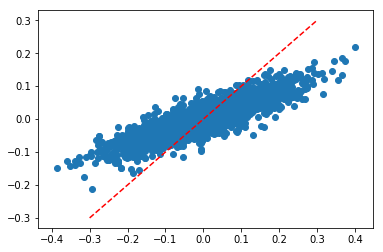

In [17]:
plt.scatter(w0,w_infer)
plt.plot([-0.3,0.3],[-0.3,0.3],'r--')